# Project: Mark Evans Movie Dataset Investigation.

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> I have selected to analyze the movie dataset. The Movie Database (TMDb) is a community built movie and TV database. Every piece of data has been added by thier community dating back to 2008. 

>Each record relates to one moive and provides related information including:
> - imdb_id
> - popularity
> - budget
> - revenue
> - original title
> - cast
> - homepage
> - director
> - tagline
> - keywords
> - overview
> - runtime
> - genres
> - production companies
> - release date
> - vote count
> - vote average
> - release year
> - budget (adjusted)
> - revenue (adjusted)

>I want to explore the data to answer the following questions:
 > - Do things like genre, budget, and revenue impact ratings (vote average)?
 > - Has the average movie budget increased over the last 15 years?
 > - Has the total dollars spent making movies increased year over year?
 > - Has certain genres of movies increased revenue over the last 15 years?

In [42]:
import pandas as pd
import numpy as np
import requests
import csv
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 21)
pd.set_option('display.max_rows', 200)

In [43]:
# create function to read CSV files from a data source and load to a pandas dataframe
def readCSVTODataFrame(csvURL):
    with requests.Session() as s:
        download = s.get(csvURL)

        decoded_content = download.content.decode('utf-8')

        cr = csv.reader(decoded_content.splitlines(), delimiter=',')

        my_list = list(cr)


        df = pd.DataFrame(my_list)

        df.columns = df.iloc[0]
        df = df[1:]

        #df = df.to_dict('records')

        return df


In [44]:
# read movies db file
fileURL = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/October/59dd1c4c_tmdb-movies/tmdb-movies.csv'
df = readCSVTODataFrame(fileURL)

<a id='wrangling'></a>
## Data Wrangling

> There are several data points not needed for this analysis so I will limit the dataset to following data points:
>     - Original Title
>     - IMDB ID
>     - Budget
>     - Vote Average
>     - Vote Count
>     - Revenue (adj)
>     - Genre
>     - Release Year
>     - Budget (adjusted)

> Additional Data Wrangling:
>  - To perform the analysis I need to convert the budget, vote average, and revenue (adjusted) to a numeric to perform calculations. 
>  - I opted to use the "adjusted" revenue instead of original revenue. 
>  - I am filter out all records that have less than 100 votes and budget greater than 0.  The results are skewed when 0 budget results are included and to few votes.
>  - I am mostly interested in trends in the last 15 years so I filtered out all movies prior to 2000 (the dataset only goes to 2015)
>  - Categories are created for Genres to help with analysis (FYI, this wrangling is done when looking for correlation between genre and revenue)

In [45]:
# extract only the needed variables
budget_rating = df[['original_title','imdb_id','budget','vote_average','vote_count','revenue_adj','genres','release_year','budget_adj']]

#Filter out movies with no budget and less than 100 reviews
filtered_budget_rating = budget_rating.loc[(budget_rating['budget'] > '0')&(budget_rating['vote_count'] >= '100')&(budget_rating['release_year'] >= '2000')]

#change budget and vote average (user rating to numeric)
filtered_budget_rating[['budget', 'vote_average','revenue_adj']] \
    = filtered_budget_rating[['budget', 'vote_average','revenue_adj']].apply(pd.to_numeric)

pd.set_option('display.max_columns', 21)
pd.set_option('display.max_rows', 20)

print(filtered_budget_rating)

0                   original_title    imdb_id     budget  vote_average  \
1                   Jurassic World  tt0369610  150000000           6.5   
2               Mad Max: Fury Road  tt1392190  150000000           7.1   
3                        Insurgent  tt2908446  110000000           6.3   
4     Star Wars: The Force Awakens  tt2488496  200000000           7.5   
5                        Furious 7  tt2820852  190000000           7.3   
...                            ...        ...        ...           ...   
8869                The Big Kahuna  tt0189584    7000000           6.5   
8871         All the Pretty Horses  tt0149624   57000000           5.5   
8876                    Ð‘Ñ€Ð°Ñ‚ 2  tt0238883    1500000           7.4   
8882                    Hanging Up  tt0162983   40000000           5.2   
8884                  The In Crowd  tt0163676   15000000           5.2   

0    vote_count   revenue_adj                                     genres  \
1          5562  1.392446e+09  Acti

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


<a id='eda'></a>
## Exploratory Data Analysis


### Do things like genre, budget, and revenue impact ratings (vote average)?

>  I first calculated the mean budget and rating.  I used this to see if movies with an above average budget also has an above average rating
OR if a below average budget also has a below average rating.
> The assumption is, if most movies have a ABOVE or BELOW correlation between cost and rating, then budget has an impact on ratings

In [46]:
#set variables - determine budget and rating mean
budget_mean = filtered_budget_rating.budget.mean()
rating_mean = filtered_budget_rating.vote_average.mean()

# Determine the # of movies that are above the mean budget and rating or below to look for correlation
both_above_below = sum(
        (filtered_budget_rating.budget >= budget_mean)
         &
        (filtered_budget_rating.vote_average >= rating_mean)
      |
        (filtered_budget_rating.budget < budget_mean)
         &
        (filtered_budget_rating.vote_average < rating_mean)
        )

total_records = filtered_budget_rating.shape[0]


print( 'The budget mean is: ', budget_mean,'The rating mean is: ',rating_mean)
print('The total number of movies that have a budget & rating correlation is ',both_above_below,' out of ',total_records, ' total movies.')

The budget mean is:  36098203.82085081 The rating mean is:  5.957489514679458
The total number of movies that have a budget & rating correlation is  1756  out of  3338  total movies.


### Do things like genre, budget, and revenue impact ratings (vote average)?

> Next I calculated correlation by using the pandas correlation methods of: Person, Kendall, and Spearman.
>  Each method is used to calculate correlation between:
>  - Budget and Rating
>  - Revenue and Rating
>  - Genre and Rating. The 'primary' (first listed) genre is used in this calculation

Pearson correlation between budget and rating is: 0.16941975427312717
Kendall correlation between budget and rating is: 0.09584203904830976
Kendall correlation between budget and rating is: 0.13758571543087925
 
Pearson correlation between revenue and rating is: 0.2781912291705806
Kendall correlation between revenue and rating is: 0.22495905814517467
Kendall correlation between revenue and rating is: 0.31675116514220847
 
Pearson correlation between genre and rating is: -0.027671179530617353
Kendall correlation between genre and rating is: 0.014060357800090054
Kendall correlation between genre and rating is: 0.017067171723274023


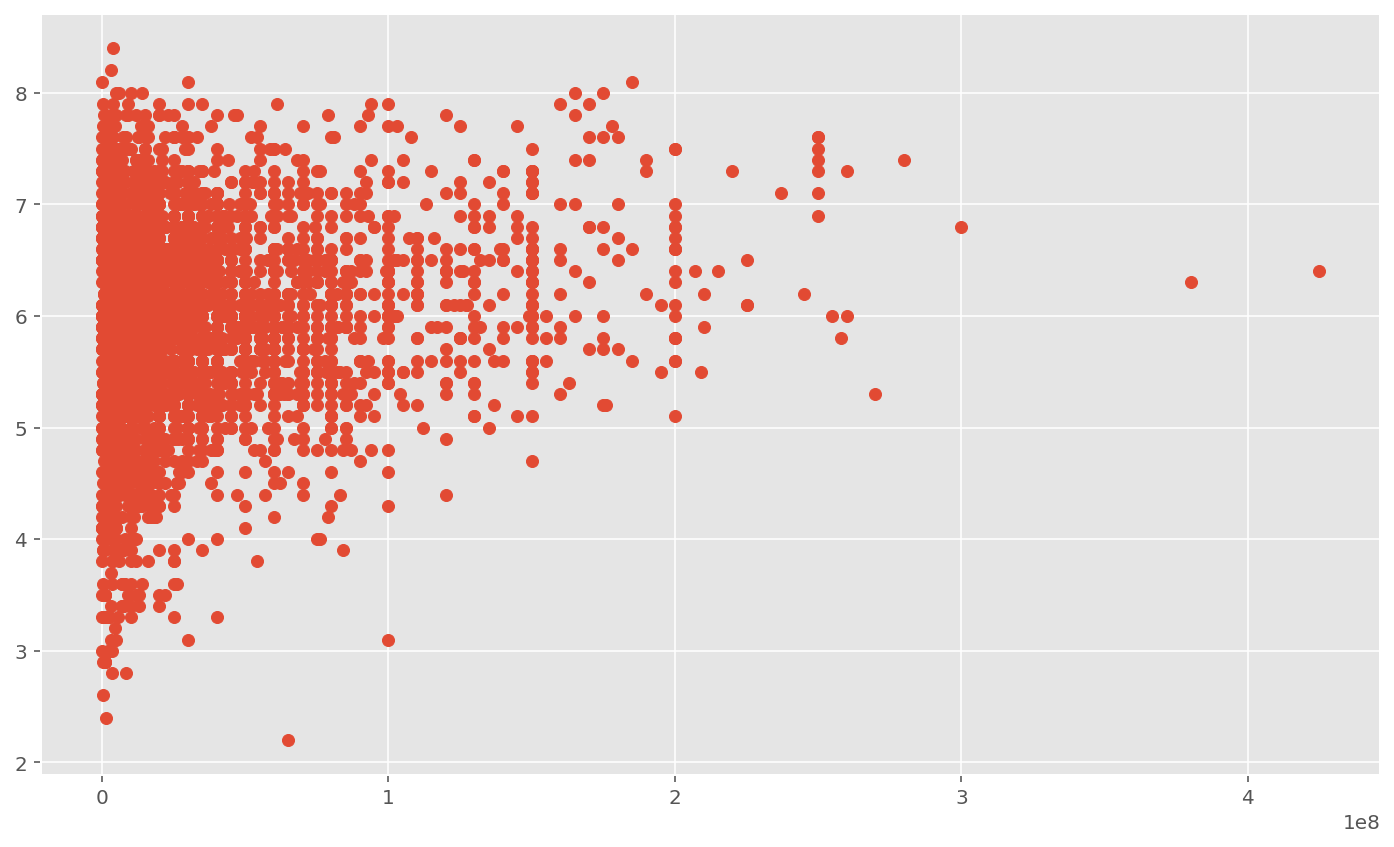

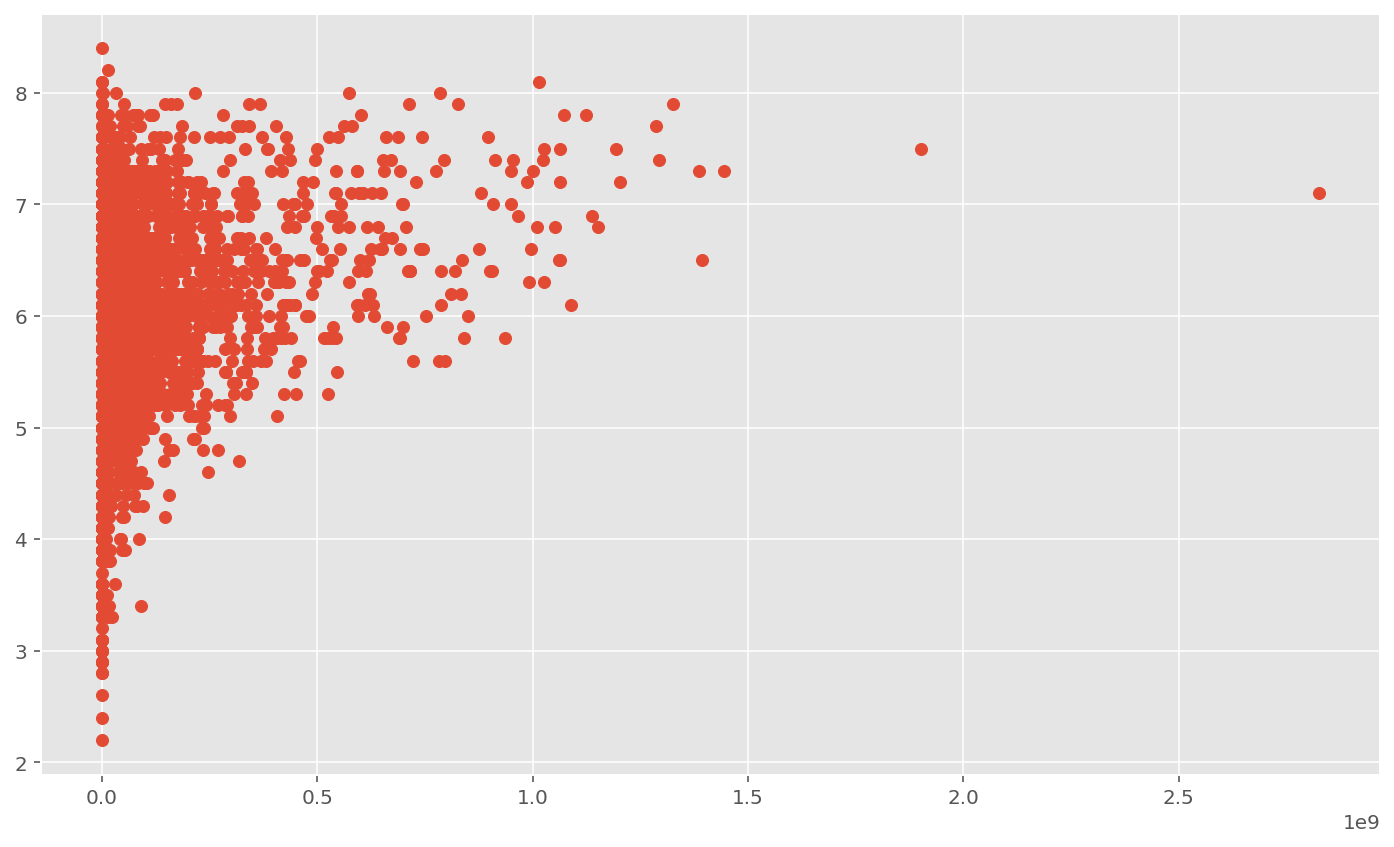

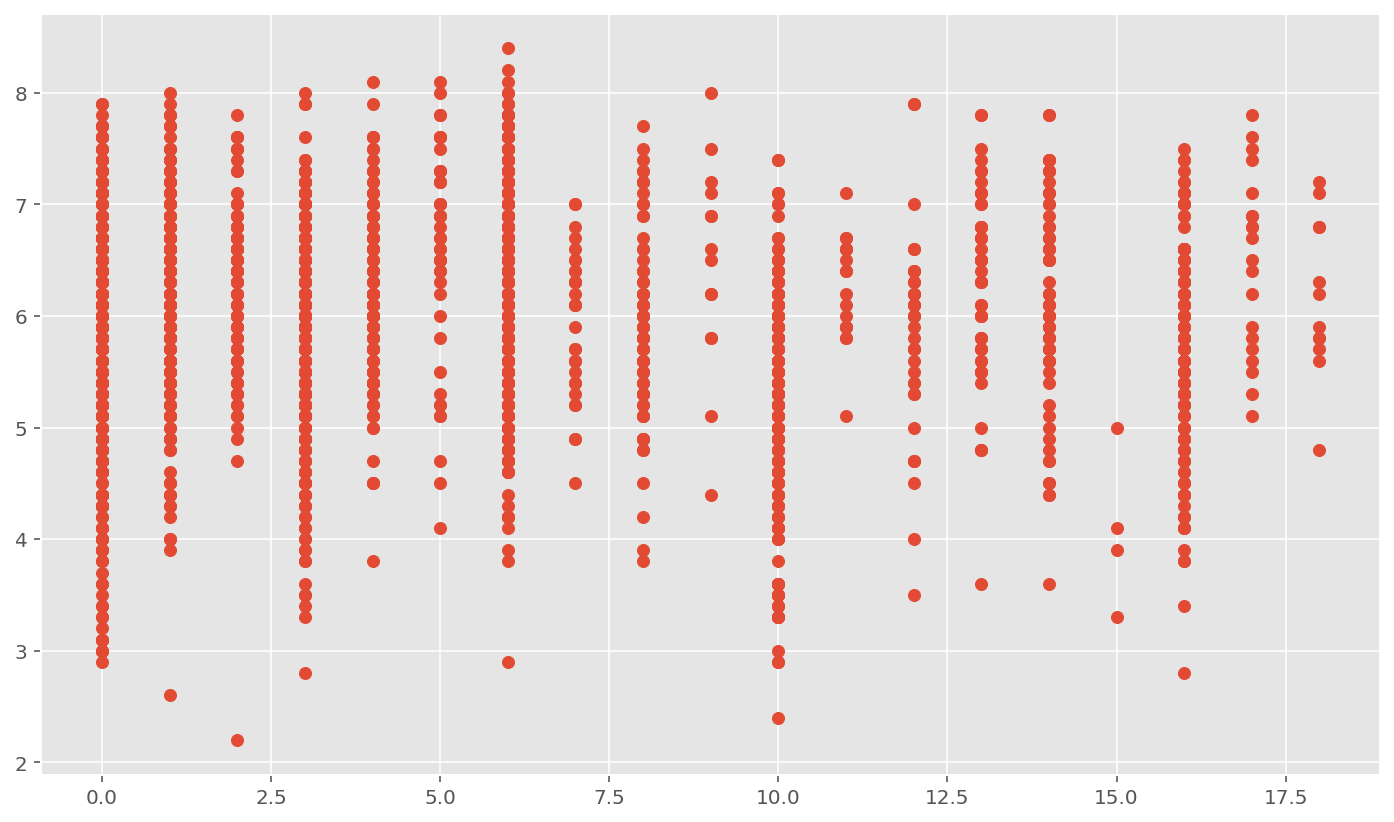

In [61]:
#get series to calculate correlations based on budget and rating
seriesBudget = pd.Series(filtered_budget_rating['budget'])
seriesRating = pd.Series(filtered_budget_rating['vote_average'])
pearson_cor1 = seriesBudget.corr(seriesRating, method='pearson')
kendall_cor1 = seriesBudget.corr(seriesRating, method='kendall')
spearman_cor1 = seriesBudget.corr(seriesRating, method='spearman')

#get series to calculate correlations based on revenue
s1 = pd.Series(filtered_budget_rating['revenue_adj'])
s2 = pd.Series(filtered_budget_rating['vote_average'])
pearson_cor2 = s1.corr(s2, method='pearson')
kendall_cor2 = s1.corr(s2, method='kendall')
spearman_cor2 = s1.corr(s2, method='spearman')

#Get genres and set to categories to run correlation based
genresseries = pd.Series(filtered_budget_rating['genres'])
genresseries = genresseries.str.split('|',expand=True)
genresseries = genresseries[0]
genrevalues = genresseries.astype('category').cat.codes.astype(np.int64)
#print(genrevalues,genresseries)

#test for correlation between genre and rating
pearson_cor3 = genrevalues.corr(seriesRating, method='pearson')
kendall_cor3 = genrevalues.corr(seriesRating, method='kendall')
spearman_cor3 = genrevalues.corr(seriesRating, method='spearman')

print('Pearson correlation between budget and rating is:',pearson_cor1)
print('Kendall correlation between budget and rating is:',kendall_cor1)
print('Kendall correlation between budget and rating is:',spearman_cor1)
print(' ')

print('Pearson correlation between revenue and rating is:',pearson_cor2)
print('Kendall correlation between revenue and rating is:',kendall_cor2)
print('Kendall correlation between revenue and rating is:',spearman_cor2)
print(' ')
print('Pearson correlation between genre and rating is:',pearson_cor3)
print('Kendall correlation between genre and rating is:',kendall_cor3)
print('Kendall correlation between genre and rating is:',spearman_cor3)


matplotlib.style.use('ggplot')
plt.scatter(seriesBudget, seriesRating)
plt.show()


matplotlib.style.use('ggplot')
plt.scatter(s1, s2)
plt.show()


matplotlib.style.use('ggplot')
plt.scatter(genrevalues, seriesRating)
plt.show()


### Has the average movie budget increased over the last 15 years?

>  I have graphed the average movie budget by year to visualize the trend over 15 years.

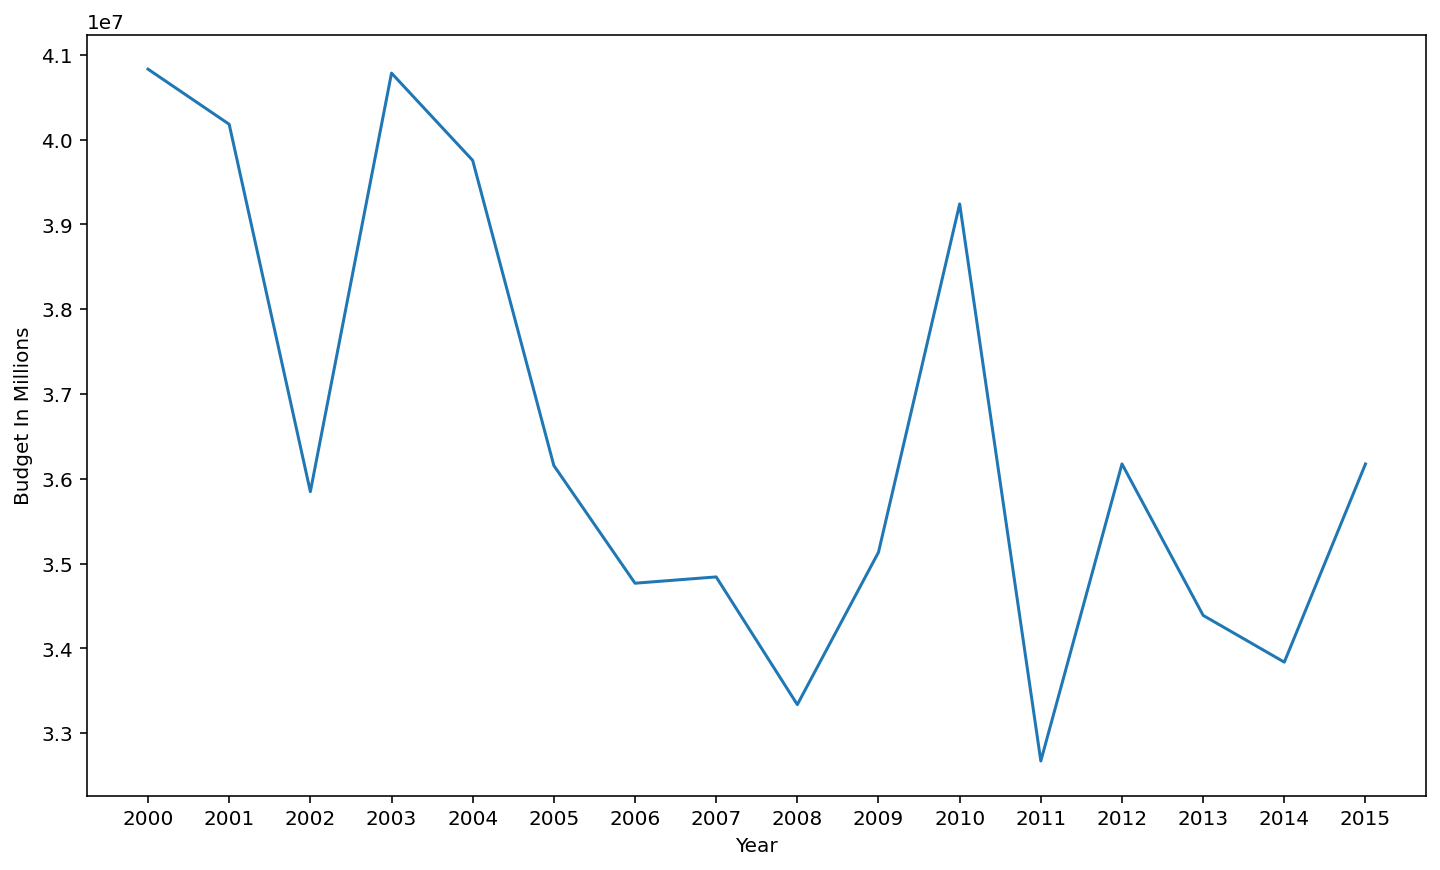

In [48]:
#Calculate mean budget by year
avg_budget_by_year = filtered_budget_rating[['release_year','budget']]
avg_budget_15_years = avg_budget_by_year.loc[(filtered_budget_rating['release_year'] >= '2000')]
avg_budget_15_years = avg_budget_15_years.groupby('release_year')['budget'].mean()

plt.plot(avg_budget_15_years)
plt.xlabel('Year')
plt.ylabel('Budget In Millions')
plt.show()


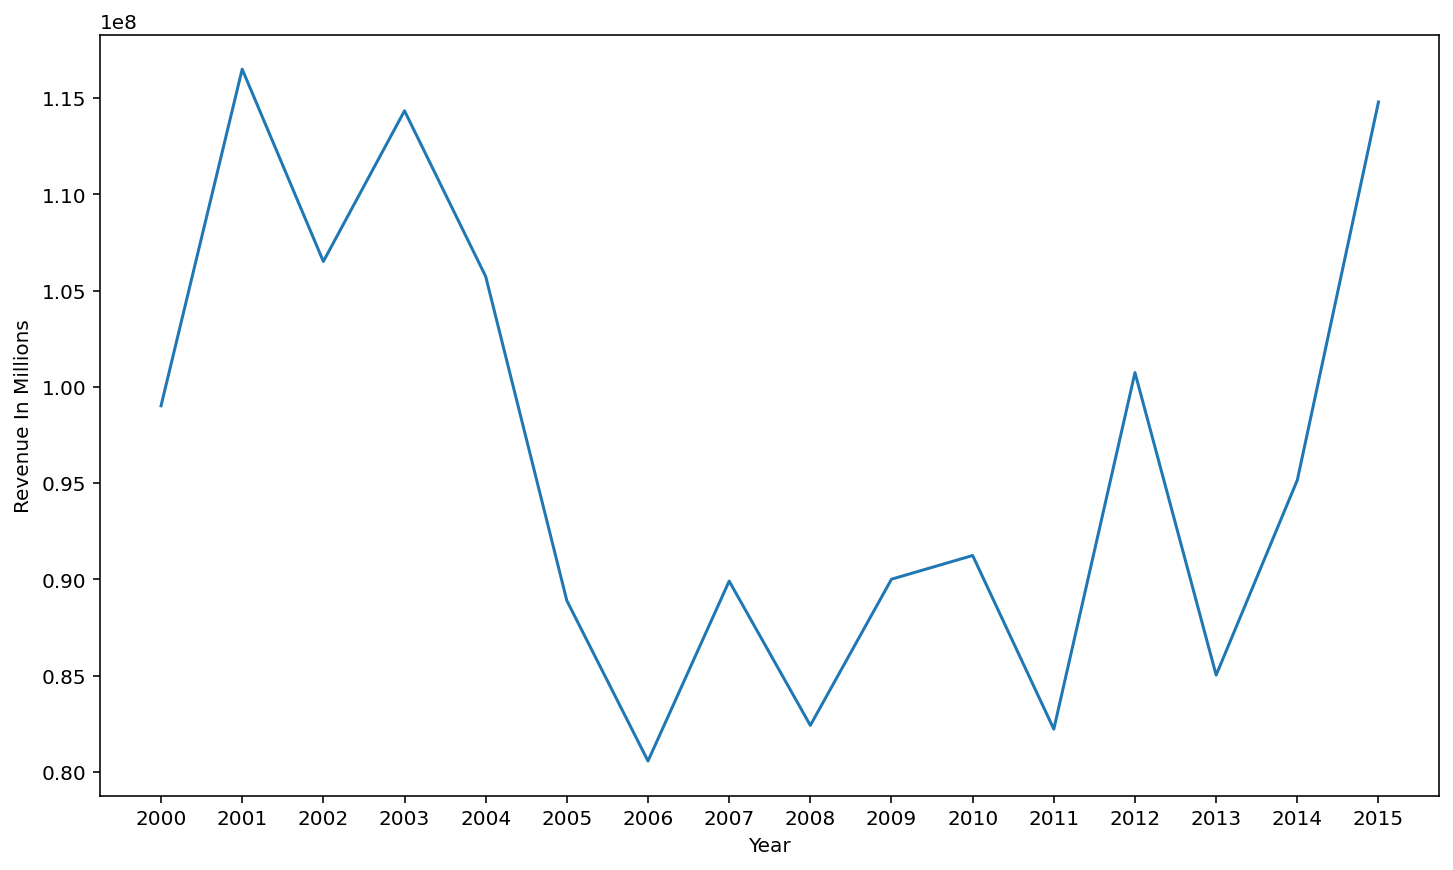

In [49]:
#Calculate mean revenue by year
avg_budget_by_year = filtered_budget_rating[['release_year','revenue_adj']]
avg_budget_15_years = avg_budget_by_year.loc[(filtered_budget_rating['release_year'] >= '2000')]
avg_budget_15_years = avg_budget_15_years.groupby('release_year')['revenue_adj'].mean()

plt.plot(avg_budget_15_years)
plt.xlabel('Year')
plt.ylabel('Revenue In Millions')
plt.show()

### Has the total dollars spent making movies increased year over year?

>  I have calculated the total budget (dollars spent) by year to visualize the trend over 15 years.

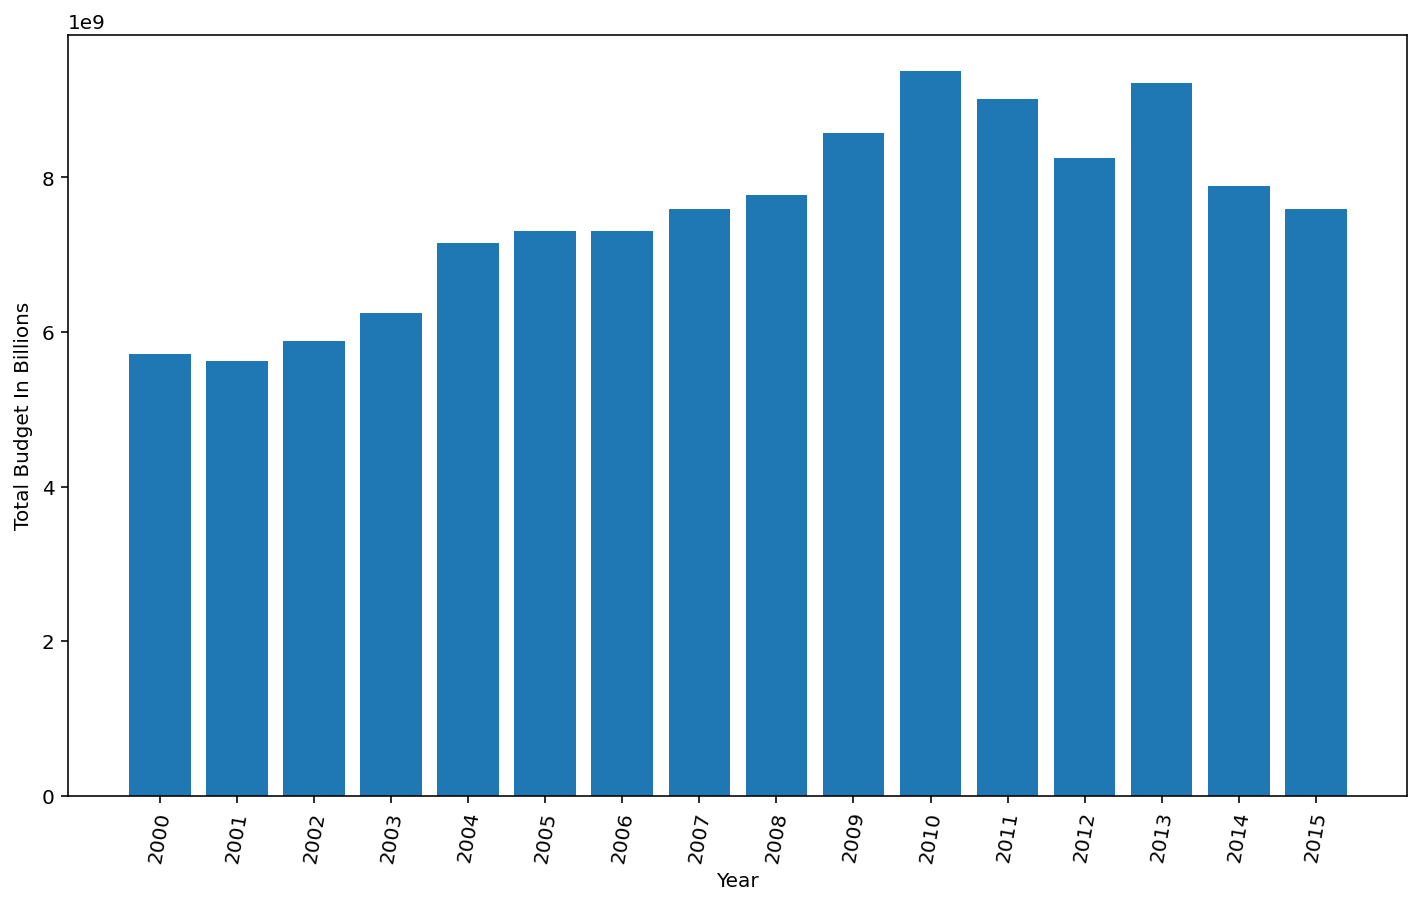

In [50]:
total_budget_by_year = filtered_budget_rating[['release_year','revenue_adj','budget']]
total_budget_by_year = total_budget_by_year.loc[(total_budget_by_year['release_year'] >= '2000')]
#avg_revenue_15_years = avg_revenue_15_years.groupby('release_year')['revenue_adj'].mean()
total_budget_by_year = total_budget_by_year.groupby('release_year')['budget'].sum()


barChart = plt
barChart.bar(x=total_budget_by_year.index,height=total_budget_by_year)
barChart.xlabel('Year')
barChart.ylabel('Total Budget In Billions')
barChart.xticks(rotation=80)
barChart.show()

#plt.plot(avg_revenue_15_years)
#plt.xlabel('Year')
#plt.ylabel('Budget In Millions')
#plt.show()

### Has certain genres of movies increased revenue over the last 15 years?

>  I have calculated the mean revenue by year and by genre to visualize a trend over 15 years.


<ipython-input-51-b1c88c1eac44>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_budget_rating['first_genre'] = filtered_budget_rating['genres'].str.split('|',expand=True)[0]


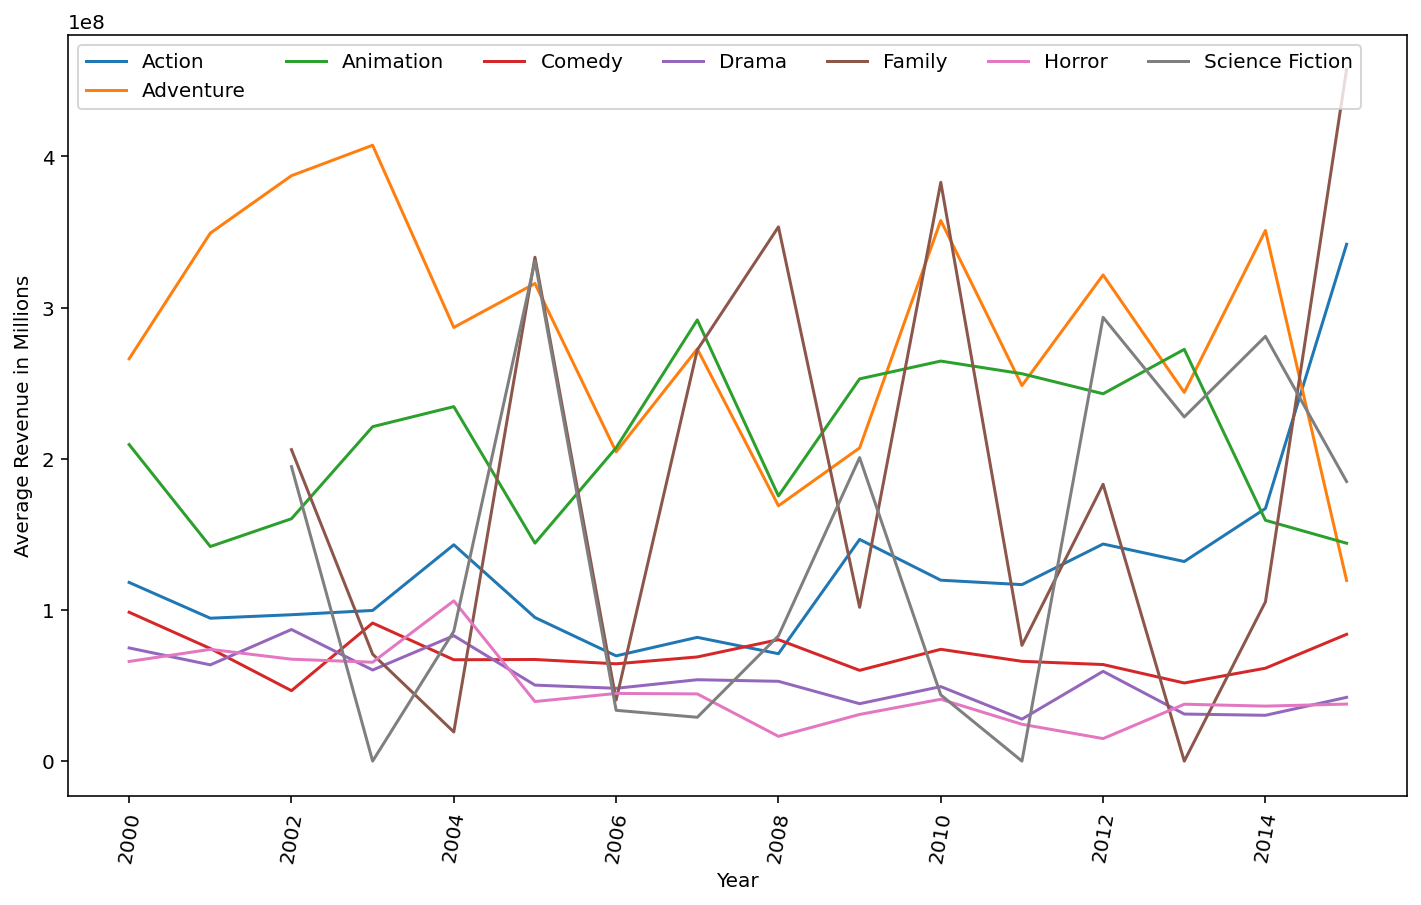

In [51]:
#genresseries
#filtered_budget_rating
filtered_budget_rating['first_genre'] = filtered_budget_rating['genres'].str.split('|',expand=True)[0]

year_genre_budget = filtered_budget_rating[['release_year','first_genre','budget','revenue_adj']]

year_genre_budget = year_genre_budget.loc[year_genre_budget['first_genre'].isin(['Action','Comedy','Drama','Family','Horror','Adventure','Animation','Science Fiction'])]

#year_genre_budget = year_genre_budget.loc[year_genre_budget['first_genre'].isin(['Action','Comedy','Drama','Family','Fantasy','Horror','Adevnture', 'Animation','Science'])


#Action,Comedy,Drama, Family, Fantasy, Horror, Adevnture, Animation,Science Fiction
#year_genre_budget = year_genre_budget.groupby(['first_genre','release_year'])['budget'].mean().sort_index(ascending=True)

#year_genre_budget.index
#year_genre_budget

#ax = plt.subplots(figsize=(15,7))
year_genre_budget.groupby(['release_year','first_genre']).mean()['revenue_adj'].unstack().plot()
plt.xticks(rotation=80)
plt.legend(loc=2,markerscale=0,fontsize=10,ncol = 7)
plt.xlabel('Year')
plt.ylabel('Average Revenue in Millions')
plt.show()


#linechart.xticks(rotation=80)
#linechart.show()

#mi = pd.MultiIndex.from_tuples(year_genre_budget.index, names=('genre', 'year'))

#year_genre_budget.values
#plt.plot(y = mi.get_level_values(0),x=year_genre_budget.values)


#type(year_genre_budget)
#plt.plot(data=year_genre_budget)
#plt.xticks(rotation=80)
#plt.show()
#year_genre_budget

<a id='conclusions'></a>
## Conclusions

>Based on my analysis I have determined the following for each of the questions asked:

 #####     Do things like genre, budget, and revenue impact ratings (vote average)?
 > Based on my analysis there does not appear to be any correlation between a movies rating and it's associated genre, budget or revenue.
 > Total revenue has the highest correlation of the 3, however it would not be considered to be a high correlation.
 ##### Has the average movie budget increased over the last 15 years?
 > There has not been an consistent increase in budget \ money spend on movies in the last 15 years.
 >
 ##### Has the total dollars spent making movies increased year over year?
 > Over the 15 years analyzed, the total dollars spent making movies has not had an stead\consistent increase.
 >It is interesting to note that the budget (cost) does follow a similar trend to revenue made.
 ##### Has certain genres of movies increased revenue over the last 15 years?
 > Only "Action" movies appear to have an increase in revenue overtime. This increase trended up over the last 7 years.
 > Family movies tend to spike up and then down over a 1 to 2 year period, however it experienced a drastic increase in the last 2 year.
 #### Additional Findings
 > At the outset I did not plan to compare budget to revenue to look for correlation, however based on my analysis it appears, based on the variables I looked at, that budget does have an correlation to revenue.
 > This supports the idea, "You have to spend money to make money" :)
 > I have added an additional chart and correlation calculations below to illustrate this correlation.
 
 
 

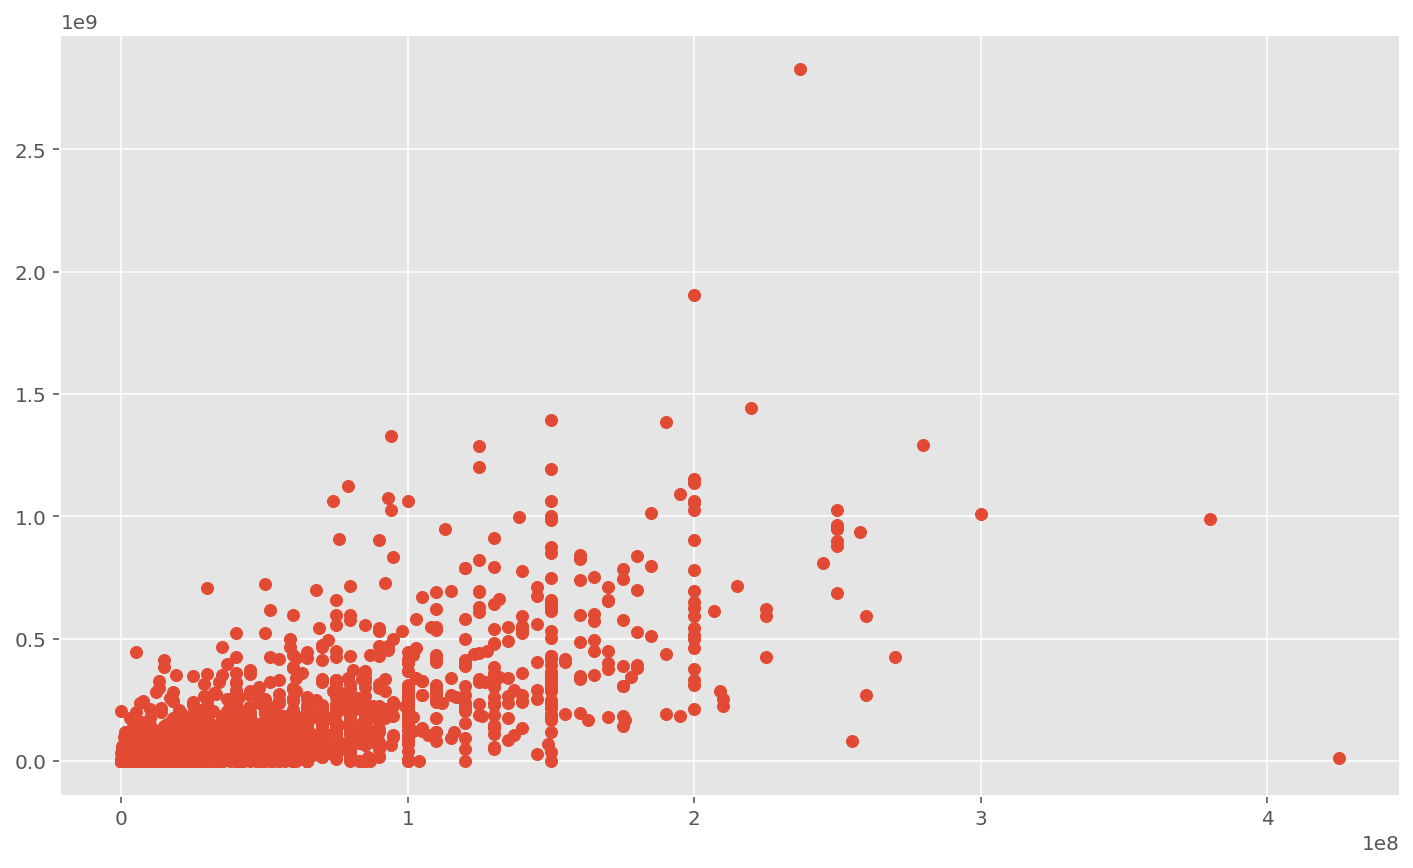

0.7363492801725832 0.555863332550069 0.7281408678751939


In [58]:


revenue = filtered_budget_rating['revenue_adj']
budget = filtered_budget_rating['budget']


pearson_cor2 = budget.corr(revenue, method='pearson')
kendall_cor2 = budget.corr(revenue, method='kendall')
spearman_cor2 = budget.corr(revenue, method='spearman')


matplotlib.style.use('ggplot')
plt.scatter(budget, revenue)
plt.show()

print(pearson_cor2,kendall_cor2,spearman_cor2)